<a href="https://colab.research.google.com/github/MohammedHamood/MLP/blob/main/MultilayerPerceptron.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#MultilayerPerceptron
this notebook contain the implementation of the MLP. CIFAR10 is trained and tested using MLP. 

In [ ]:
import numpy as np
import pandas as pd
from time import time
from sklearn.metrics import accuracy_score


import os




import pickle

from IPython.display import Image,display
import matplotlib.pyplot as plt
import random


import math
from sklearn import datasets

import torch
import torchvision
import torchvision.transforms as transforms

import scipy.io
from random import shuffle



import gzip
import pickle

import os
import urllib
from threading import Lock

# Pre-processing functions
all needed functions are provided here to easy use and modify.

## Preprocessing 

In [ ]:
def preprocess(X,y): 
    X = X.reshape(-1, 3072)# reshape the fitures of 3 layers image into one vector of length 3072
    y = one_hot_encode(y)# convert output into cateegoral 
    y = y.reshape(-1, 10)
    return X, y
def one_hot_encode(data):
    one_hot = np.zeros((data.shape[0], 10))
    one_hot[np.arange(data.shape[0]), data] = 1
    return one_hot 



def normalize(X, axis=-1, order=2):# normalize features
    """ Normalize the dataset X """
    l2 = np.atleast_1d(np.linalg.norm(X, order, axis))
    l2[l2 == 0] = 1
    return X / np.expand_dims(l2, axis)

def train_validate_split(X, y, test_size=0.5, shuffle=True, seed=None):
    """ Split the data into train and test sets """
    if shuffle:
        X, y = shuffle_data(X, y, seed)
    # Split the training data from test data in the ratio specified in
    # test_size
    split_i = len(y) - int(len(y) // (1 / test_size))
    X_train, X_test = X[:split_i], X[split_i:]
    y_train, y_test = y[:split_i], y[split_i:]

    return X_train, X_test, y_train, y_test

def train_validate_split_2(X, y, ratio=0.8):
    split = int(ratio * X.shape[0])
    indices = np.random.permutation(X.shape[0])
    training_idx, val_idx = indices[:split], indices[split:]
    X_train, X_val = X[training_idx, :], X[val_idx, :]
    y_train, y_val = y[training_idx, :], y[val_idx, :]
    print ("Records in Training Dataset", X_train.shape[0])
    print ("Records in Validation Dataset", X_val.shape[0])
    return X_train, y_train, X_val, y_val


def shuffle_data(X, y, seed=None):
    if seed:
        np.random.seed(seed)
    idx = np.arange(X.shape[0])
    np.random.shuffle(idx)
    return X[idx], y[idx]

##Visualization

In [ ]:
def plot_training_stats(stats, plot_title, plot_acc=False, save_as_file=None):
    """
    Plots training statistics: training loss and accuracy, validation loss and accuracy
    :param stats: Statistics to plot
    :param plot_title: Title of plot
    :param plot_acc: If accuracy should be plotted in addition to loss
    :param save_as_file: Optional file name to save results under
    """
    train_loss, train_acc, valid_loss, valid_acc = stats
    plt.plot(np.arange(len(train_loss)) + 1, train_loss, label='Training Set')
    plt.plot(np.arange(len(valid_loss)) + 1, valid_loss, label='Validation Set')
    plt.title('Loss Vs. Epochs\n%s' % plot_title)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend(loc="upper right")
    if save_as_file:
        plt.savefig(os.path.join('results', 'loss_%s' % save_as_file))
    plt.show()

    if not plot_acc:
        return

    plt.plot(np.arange(len(train_acc)) + 1, train_acc, label='Training Set')
    plt.plot(np.arange(len(valid_acc)) + 1, valid_acc, label='Validation Set')
    plt.title('Accuracy Vs. Epochs\n%s' % plot_title)
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend(loc="upper right")
    if save_as_file:
        plt.savefig(os.path.join('results', 'acc_%s' % save_as_file))
    plt.show()


##Results Cache

In [ ]:

class ResultsCache(object):
    """
    Utility class for storing results of hyper-parameter search
    """
    FILE_PATH = './results/params_search.csv'

    def __init__(self, df):
        self.df = df
        self.save_lock = Lock()

    @staticmethod
    def load():
        """
        Loads the results cache. If previous results stored in the .csv file
        exist on the file-system, loads them into memory.
        """
        df = pd.read_csv(ResultsCache.FILE_PATH) if os.path.isfile(
            ResultsCache.FILE_PATH) else pd.DataFrame(
            columns=['label', 'activation', 'weight_init', 'layers', 'alpha', 'batch', 'acc'])
        return ResultsCache(df)

    def display(self):
        """
        Displays all results stored in the result cache
        """
        print('\nParameter Search Results Summary:')
        print(self.df.drop('label', 1))

    def insert(self, nn, alpha, batch, acc):
        """
        add a new result 
        :param nn: Neural network model
        :param alpha: Learning rate used to train the model
        :param batch: Batch size used to train the model
        :param acc: Validation accuracy obtained after training
        """
        label = nn.get_training_info_str(alpha, batch).replace(u'\u03B1', 'alpha').replace(' ', '')

        self.save_lock.acquire()
        try:
            if not self.df.loc[self.df['label'] == label].empty:
                # Update existing entry
                self.df.loc[self.df['label'] == label, 'acc'] = acc
            else:
                # Insert new entry
                new_entry = {'label': label, 'activation': nn.activation.__name__,
                             'weight_init': nn.weight_init.__name__,
                             'layers': '-'.join([str(l) for l in nn.layer_dims]),
                             'alpha': alpha, 'batch': batch, 'acc': acc}
                self.df = self.df.append(new_entry, ignore_index=True)

            self.df = self.df.sort_values(by=['acc'], ascending=False)
            self.df.to_csv(ResultsCache.FILE_PATH, index=False)

        finally:
            self.save_lock.release()



## Activation 

In [ ]:
class Tanh(object):
    """
    Models tanh activation function and its derivative
    """
    @staticmethod
    def f(z):
        exp_plus = np.exp(z)
        exp_neg = 1. / exp_plus
        return (exp_plus - exp_neg) / (exp_plus + exp_neg)

    @staticmethod
    def df(z):
        tanh = Tanh.f(z)
        return 1. - tanh * tanh


class Sigmoid(object):
    """
    Models sigmoid activation function and its derivative
    """
    @staticmethod
    def f(z):
        return 1. / (1 + np.exp(-z))

    @staticmethod
    def df(z):
        sig = Sigmoid.f(z)
        return sig * (1 - sig)


class Relu(object):
    """
    Models relu activation function and its derivative
    """
    @staticmethod
    def f(z):
        return np.maximum(0, z)

    @staticmethod
    def df(z):
        return (z > 0).astype(int)

## Weight initialization

In [ ]:

class Zeros(object):
    """
    Initialisation scheme that sets all weights to 0
    """
    @staticmethod
    def init(dim_l, dim_l_prev):
        """
        Returns a dim_l x dim_l_prev dimensional W matrix
        """
        return np.zeros((dim_l, dim_l_prev))


class Normal(object):
    """
    Initialisation scheme that sets to the standard normal distribution (mean=0, variance=1)
    """
    @staticmethod
    def init(dim_l, dim_l_prev):
        """
        Returns a dim_l x dim_l_prev dimensional W matrix
        """
        return np.random.randn(dim_l, dim_l_prev)





class Glorot(object):
    """
    Initialisation scheme that sets weights to a uniform distribution [-d^(l), d^(l)]
    where d^(l) = sqrt(6/(dim_l-1+dim_l))
    """
    @staticmethod
    def init(dim_l, dim_l_prev):
        """
        Returns a dim_l x dim_l_prev dimensional W matrix
        """
        d_l = np.sqrt(6.0/(dim_l+dim_l_prev))
        return np.random.uniform(-d_l, d_l, (dim_l, dim_l_prev))

#Multilayer Perceptron class
contains the Implementation of the MLP 

In [ ]:



class NN(object):

    def __init__(self, layers_dims, activation=Sigmoid, weight_init=Glorot,limit=.00001):
        """
        Creates a new neural network instance

        """
        self.b = {}
        self.w = {}
        self.activation = activation
        self.layer_dims = layers_dims
        self.layers = len(self.layer_dims)
        self.weight_init = weight_init
        self.training_info_label = ''
        self.limit=limit

    def loss(self, y, ypred):
        """
        Computes the cross entropy loss
        """
        m = y.shape[1]
        return -(1. / m) * np.sum(np.multiply(y, np.log(ypred)))

    def initialize_weights(self):
        """
        Initialize  layers weights based the weight initializer scheme 
        """
        for l in range(1, len(self.layer_dims)):
            dim_l_prev, dim_l = self.layer_dims[l - 1], self.layer_dims[l]
            self.w[l] = self.weight_init.init(dim_l, dim_l_prev)
            self.b[l] = np.zeros((dim_l, 1))

    def softmax(self, z):

        z=z.T
        e_z = np.exp(z - np.max(z, axis=-1, keepdims=True))
        e_z=e_z / np.sum(e_z, axis=-1, keepdims=True)
        return e_z.T
    def softgradient(self, z):
        p= self.softmax( z)
        return p*(1-p)


    def Lossgradient(self, y, p):
        # Avoid division by zero
        p = np.clip(p, 1e-15, 1 - 1e-15)
        return - (y / p) + (1 - y) / (1 - p)



    def forward(self, X):
        """
        Executes a forward pass through the neural network

        """
        z, a = {}, {}

        a[0] = X
        for l in range(1, self.layers):
            z[l] = np.matmul(self.w[l], a[l - 1]) + self.b[l]
            # If last layer, output is computed using softmax, else use normal activation function configured with nn
            a[l] = self.activation.f(z[l]) if l < self.layers - 1 else self.softmax(z[l])

        return z, a

    def backward(self, z, a, y):
        """
        Executes backward propagation. Recursively computes 
        :return: Gradient values for weights (dw) and biases (db) from which weights can be adjusted by gradient descent
        """
        dz, da, dw, db = {}, {}, {}, {}
        m_batch = y.shape[1]

        for l in reversed(range(1, self.layers)):
            # If last layer compute gradient using softmax activation function. Else compute gradient using derivative
            # of normal activation function
            dz[l] = np.multiply(da[l], self.activation.df(z[l])) if l < self.layers - 1 else self.Lossgradient(y,a[self.layers - 1] )* self.softgradient(z[l])

            dw[l] = (1. / m_batch) * np.matmul(dz[l], a[l - 1].T)
            db[l] = (1. / m_batch) * np.sum(dz[l], axis=1, keepdims=True)
            da[l - 1] = np.matmul(self.w[l].T, dz[l]) if l > 1 else 0
        return dw, db

    def update(self, dw, db, alpha):
        """
        Updates weight values using mini-batch SGD
        """
        for l in range(1, self.layers):
            self.w[l] = self.w[l] - alpha * dw[l]
            self.b[l] = self.b[l] - alpha * db[l]

    def test(self, x, y):
        """
        Computes accuracy and loss for a given set of x samples and corresponding labeled y classes
        """
        z, a = self.forward(x)
        y_pred = a[self.layers - 1]
        cost = self.loss(y, y_pred)
        accuracy = accuracy_score(np.argmax(y, axis=0), np.argmax(y_pred, axis=0))
        return cost, accuracy

    def get_training_info_str(self, alpha, batch_size):
        """
        Returns a string label summarizing the training parameters
        """
        return u'g=%s, w_init=%s, layers=%s, \u03B1=%.2f, batch=%d' \
               % (self.activation.__name__, self.weight_init.__name__,
                  '-'.join([str(l) for l in self.layer_dims]), alpha, batch_size)



    def train(self, train_set, valid_set, alpha=0.1, epochs=20, batch_size=128, verbose=True):
        """
        Trains the neural network
        return: Statistics from training: training set loss and accuracy, validation loss and accuracy
        """

        self.initialize_weights()
        x_train = train_set.data.T 
        y_train = train_set.targets.T
        x_valid = valid_set.data.T
        y_valid = valid_set.targets.T

        m = x_train.shape[1]
        n_batches = int(np.ceil(float(m) / batch_size))
        train_lost = np.zeros(epochs)
        train_acc = np.zeros(epochs)
        valid_lost = np.zeros(epochs)
        valid_acc = np.zeros(epochs)

        start = time()
        self.training_info_label = self.get_training_info_str(alpha, batch_size)
        if verbose:
            print("\nTRAINING: %s" % self.training_info_label)
        temp=-1
        for i in range(epochs):
            rand_order = np.random.permutation(m)
            x_shuffled = x_train[:, rand_order]
            y_shuffled = y_train[:, rand_order]

            for k in range(n_batches):
                begin = k * batch_size
                end = min(begin + batch_size, m - 1)
                x_batch = x_shuffled[:, begin:end]
                y_batch = y_shuffled[:, begin:end]

                z, a = self.forward(x_batch)
                dw, db = self.backward(z, a, y_batch)
                self.update(dw, db, alpha)

            train_lost[i], train_acc[i] = self.test(x_train, y_train)
            valid_lost[i], valid_acc[i] = self.test(x_valid, y_valid)
            temp2=valid_acc[i]
            if verbose:
                print("Epoch %d: TrainLoss=%f, TrainAcc=%f, ValidLoss=%f, ValidAcc=%f"
                      % (i + 1, train_lost[i], train_acc[i], valid_lost[i], valid_acc[i]))
            if abs(temp-valid_lost[i])<self.limit:
                temp2=valid_acc[i]
                break
            temp=valid_lost[i]
              
        print("DONE (%ds): %s - ValidAcc=%f" % (time() - start, self.training_info_label, temp2))
        return train_lost, train_acc, valid_lost, valid_acc


class NNFactory(object):
    """
    Factory helper class for creating neural network models
    """
    CLASSES = 10
    FEATURES_VECTOR = 3072

    @staticmethod
    def create(hidden_dims, activation=Sigmoid, weight_init=Glorot, in_dim=FEATURES_VECTOR, out_dim=CLASSES, rand_seed=1):
        """
        Creates a new neural network instance
        :param hidden_dims: Number of hidden dimensions
        :param activation: Activation function: [Sigmoid, Tanh, Relu]
        :param weight_init: Weight initialization scheme: [Zeros, Normal, Glorot]
        :param in_dim: Input dimension
        :param out_dim: Output dimension (number of classes)
        :param rand_seed: Optional seed for reproducibility of results. Used when initializing random weights
        :return: Created neural network model
        """
        if rand_seed is not None:
            np.random.seed(rand_seed)
        layer_dims = [in_dim] + hidden_dims + [out_dim]
        return NN(layer_dims, activation, weight_init)

##helping functions

In [ ]:
def loaddata():
    transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
#    transforms.RandomCrop(32, padding=4),transforms.RandomHorizontalFlip(),
    trainset = torchvision.datasets.CIFAR10(root='./data', train=True,download=True, transform=transform)
    testset = torchvision.datasets.CIFAR10(root='./data', train=False,download=True, transform=transform)


    trainset.data,trainset.targets=preprocess(np.array(trainset.data),np.array(trainset.targets))
    testset.data,testset.targets=preprocess(np.array(testset.data),np.array(testset.targets)) 

    validation=torchvision.datasets.CIFAR10(root='./data', train=True,download=True, transform=transform)# just to generate object
    
    
    trainset.data = normalize(trainset.data)
    testset.data = normalize(testset.data)
    trainset.data,validation.data,trainset.targets,validation.targets = train_validate_split(trainset.data, trainset.targets, test_size=0.1, seed=1)
    return trainset,validation,testset


def weight_initialization_test():
    """
    Plots the validation and training loss for different weight initialization schemes: [Zeros, Normal, Glorot]
    """
    
    trainset,validation,testset=loaddata()
    weight_inits = [Zeros, Normal, Glorot]

    for weight_init in weight_inits:
        net = NNFactory.create(hidden_dims=[32], activation=Sigmoid, weight_init=weight_init)
        stats = net.train(trainset, validation, alpha=0.1, batch_size=32)
        plot_training_stats(stats, plot_title=net.training_info_label,
                            save_as_file='weight_init_{}.png'.format(net.weight_init.__name__))






def modelTest():
    trainset,validation,testset=loaddata()
    print(trainset.data.shape)
    net = NNFactory.create(hidden_dims=[68,16], activation=Sigmoid, weight_init=Normal)
    stats = net.train(trainset, validation, alpha=0.1, batch_size=32,epochs=20)
    plot_training_stats(stats, plot_title=net.training_info_label, plot_acc=True)


    # Build model test
    #  Weight initialization


def ModelSelection(LayersCase=1):
    """
    Searches for optimal hyper-parameter settings for the model by
    comparing the validation accuracy for different model configurations
    """
    activations = [ Relu,Sigmoid,Tanh]
    alphas = [0.1, .01]
    batch_sizes = [32,100]
    if LayersCase==1:
        hidden_layers = [[100],[148],[64],[128],[200],[16],[32],[10]]        
    elif LayersCase==2:
        hidden_layers = [[128, 64], [128, 32],[200, 32],[16,10],[12,10],[32,16]]        
    elif LayersCase==3:
        hidden_layers = [[128,32, 16],[148,64, 16],[128,64, 32],[128,32, 16],[200,100,32],[32,16,10]]
    weight_inits = [Glorot]

    trainset,validation,testset=loaddata()
    results_cache = ResultsCache.load()
    params = [(g, h, a, b, w)
              for g in activations for a in alphas for b in batch_sizes
              for h in hidden_layers for w in weight_inits]

    for (g, h, a, b, w) in params:
        net = NNFactory.create(h, activation=g, weight_init=w)
        train_loss, train_acc, valid_loss, valid_acc = net.train(trainset, validation, alpha=a,epochs=200, batch_size=b, verbose=False)
        results_cache.insert(net, a, b, valid_acc[-1])
        f = open('./results/train_loss.csv', 'a')
        f.write(net.training_info_label.replace(u'\u03B1', 'alpha'))
        f.write(np.array_str(train_loss))
        f.write('\n')
        f.close()         
        
        f = open('./results/train_acc.csv', 'a')
        f.write(net.training_info_label.replace(u'\u03B1', 'alpha'))
        f.write(np.array_str(train_acc))
        f.write('\n')
        f.close()
                 
        f = open('./results/valid_loss.csv', 'a')
        f.write(net.training_info_label.replace(u'\u03B1', 'alpha'))
        f.write(np.array_str(valid_loss))
        f.write('\n')
        f.close()
                 
        f = open('./results/valid_acc.csv', 'a')
        f.write(net.training_info_label.replace(u'\u03B1', 'alpha'))
        f.write(np.array_str(valid_acc))
        f.write('\n')
        f.close()


    results_cache.display()  


## Train the MLP
First, we examine the convergence of the MLP. Results shows slow convergence for loss using Normal distribution intialization.

Files already downloaded and verified
Files already downloaded and verified
(45000, 3072)

TRAINING: g=Sigmoid, w_init=Normal, layers=3072-68-16-10, α=0.10, batch=32
Epoch 1: TrainLoss=2.116768, TrainAcc=0.197911, ValidLoss=2.120963, ValidAcc=0.191600
Epoch 2: TrainLoss=2.063495, TrainAcc=0.212289, ValidLoss=2.076030, ValidAcc=0.202600
Epoch 3: TrainLoss=2.023347, TrainAcc=0.236133, ValidLoss=2.031256, ValidAcc=0.233200
Epoch 4: TrainLoss=1.955256, TrainAcc=0.283222, ValidLoss=1.970285, ValidAcc=0.277600
Epoch 5: TrainLoss=1.938714, TrainAcc=0.293511, ValidLoss=1.954121, ValidAcc=0.280000
Epoch 6: TrainLoss=1.947953, TrainAcc=0.295556, ValidLoss=1.958656, ValidAcc=0.295600
Epoch 7: TrainLoss=1.892258, TrainAcc=0.319244, ValidLoss=1.908142, ValidAcc=0.310000
Epoch 8: TrainLoss=1.919097, TrainAcc=0.296533, ValidLoss=1.929453, ValidAcc=0.289600
Epoch 9: TrainLoss=1.863942, TrainAcc=0.333400, ValidLoss=1.880584, ValidAcc=0.326600
Epoch 10: TrainLoss=1.937583, TrainAcc=0.305844, ValidLoss=1

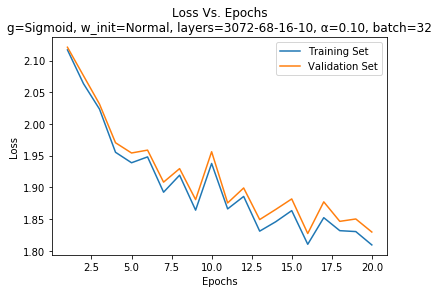

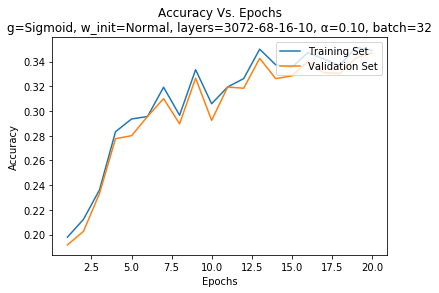

In [ ]:
modelTest()



## Weight initialization
Three ways for initialization the weights and bais parameters are tested here. Xavire Glorot scheme shows better conversions 

Files already downloaded and verified
Files already downloaded and verified

TRAINING: g=Sigmoid, w_init=Zeros, layers=3072-32-10, α=0.10, batch=32
Epoch 1: TrainLoss=2.309609, TrainAcc=0.100022, ValidLoss=2.309636, ValidAcc=0.099800
Epoch 2: TrainLoss=2.307965, TrainAcc=0.099956, ValidLoss=2.306680, ValidAcc=0.100400
Epoch 3: TrainLoss=2.309962, TrainAcc=0.099756, ValidLoss=2.307862, ValidAcc=0.102200
Epoch 4: TrainLoss=2.309448, TrainAcc=0.099822, ValidLoss=2.308912, ValidAcc=0.101600
Epoch 5: TrainLoss=2.306756, TrainAcc=0.100022, ValidLoss=2.305384, ValidAcc=0.099800
Epoch 6: TrainLoss=2.310973, TrainAcc=0.100089, ValidLoss=2.309277, ValidAcc=0.099200
Epoch 7: TrainLoss=2.308730, TrainAcc=0.099822, ValidLoss=2.307681, ValidAcc=0.101600
Epoch 8: TrainLoss=2.318261, TrainAcc=0.100289, ValidLoss=2.318424, ValidAcc=0.097400
Epoch 9: TrainLoss=2.309663, TrainAcc=0.100089, ValidLoss=2.309167, ValidAcc=0.099200
Epoch 10: TrainLoss=2.310546, TrainAcc=0.099956, ValidLoss=2.311588, ValidAcc=

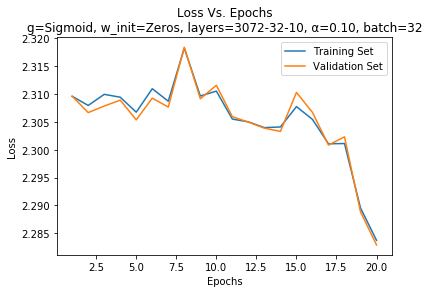


TRAINING: g=Sigmoid, w_init=Normal, layers=3072-32-10, α=0.10, batch=32
Epoch 1: TrainLoss=2.120410, TrainAcc=0.213956, ValidLoss=2.126043, ValidAcc=0.209000
Epoch 2: TrainLoss=2.030716, TrainAcc=0.262000, ValidLoss=2.043584, ValidAcc=0.249800
Epoch 3: TrainLoss=1.988069, TrainAcc=0.282378, ValidLoss=2.000178, ValidAcc=0.268600
Epoch 4: TrainLoss=1.950217, TrainAcc=0.304289, ValidLoss=1.963084, ValidAcc=0.287200
Epoch 5: TrainLoss=1.928372, TrainAcc=0.309044, ValidLoss=1.939438, ValidAcc=0.300200
Epoch 6: TrainLoss=1.911887, TrainAcc=0.320867, ValidLoss=1.926310, ValidAcc=0.305400
Epoch 7: TrainLoss=1.890829, TrainAcc=0.328089, ValidLoss=1.904629, ValidAcc=0.313600
Epoch 8: TrainLoss=1.893156, TrainAcc=0.326044, ValidLoss=1.907807, ValidAcc=0.313200
Epoch 9: TrainLoss=1.886252, TrainAcc=0.321889, ValidLoss=1.896165, ValidAcc=0.319200
Epoch 10: TrainLoss=1.863066, TrainAcc=0.347511, ValidLoss=1.878065, ValidAcc=0.333800
Epoch 11: TrainLoss=1.857523, TrainAcc=0.350889, ValidLoss=1.87123

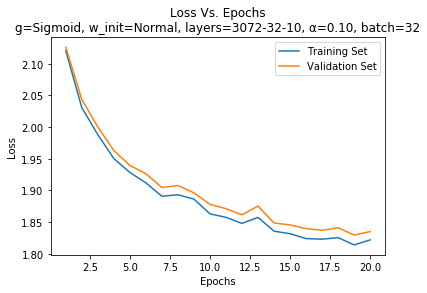


TRAINING: g=Sigmoid, w_init=Glorot, layers=3072-32-10, α=0.10, batch=32
Epoch 1: TrainLoss=2.300012, TrainAcc=0.107644, ValidLoss=2.299394, ValidAcc=0.104200
Epoch 2: TrainLoss=2.240375, TrainAcc=0.195378, ValidLoss=2.238068, ValidAcc=0.198000
Epoch 3: TrainLoss=2.146406, TrainAcc=0.197978, ValidLoss=2.146731, ValidAcc=0.199000
Epoch 4: TrainLoss=2.088930, TrainAcc=0.238400, ValidLoss=2.089609, ValidAcc=0.237600
Epoch 5: TrainLoss=2.058937, TrainAcc=0.241556, ValidLoss=2.060807, ValidAcc=0.237400
Epoch 6: TrainLoss=2.019992, TrainAcc=0.268244, ValidLoss=2.020747, ValidAcc=0.265200
Epoch 7: TrainLoss=1.986958, TrainAcc=0.282600, ValidLoss=1.991166, ValidAcc=0.269600
Epoch 8: TrainLoss=1.963052, TrainAcc=0.301067, ValidLoss=1.966372, ValidAcc=0.296800
Epoch 9: TrainLoss=1.946616, TrainAcc=0.303733, ValidLoss=1.953019, ValidAcc=0.300000
Epoch 10: TrainLoss=1.920809, TrainAcc=0.316733, ValidLoss=1.926811, ValidAcc=0.318000
Epoch 11: TrainLoss=1.908347, TrainAcc=0.318244, ValidLoss=1.91638

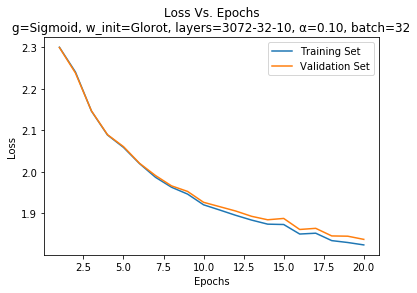

In [ ]:
weight_initialization_test()



## Parmeter selection
we aim here to select the learning rate mini-batch size and number of layers. we train through several trails. We traind every moodle for 200 trails and save its results. 

### One layer

In [ ]:
ModelSelection(LayersCase=1)

Files already downloaded and verified
Files already downloaded and verified
DONE (959s): g=Relu, w_init=Glorot, layers=3072-100-10, α=0.10, batch=32 - ValidAcc=0.463800
DONE (1282s): g=Relu, w_init=Glorot, layers=3072-148-10, α=0.10, batch=32 - ValidAcc=0.485200
DONE (730s): g=Relu, w_init=Glorot, layers=3072-64-10, α=0.10, batch=32 - ValidAcc=0.374200
DONE (1111s): g=Relu, w_init=Glorot, layers=3072-128-10, α=0.10, batch=32 - ValidAcc=0.490600
DONE (1700s): g=Relu, w_init=Glorot, layers=3072-200-10, α=0.10, batch=32 - ValidAcc=0.474800
DONE (57s): g=Relu, w_init=Glorot, layers=3072-16-10, α=0.10, batch=32 - ValidAcc=0.393400
DONE (234s): g=Relu, w_init=Glorot, layers=3072-32-10, α=0.10, batch=32 - ValidAcc=0.444800
DONE (182s): g=Relu, w_init=Glorot, layers=3072-10-10, α=0.10, batch=32 - ValidAcc=0.383000
DONE (446s): g=Relu, w_init=Glorot, layers=3072-100-10, α=0.10, batch=100 - ValidAcc=0.498600
DONE (578s): g=Relu, w_init=Glorot, layers=3072-148-10, α=0.10, batch=100 - ValidAcc=0.5

DONE (210s): g=Tanh, w_init=Glorot, layers=3072-32-10, α=0.01, batch=32 - ValidAcc=0.397600
DONE (97s): g=Tanh, w_init=Glorot, layers=3072-10-10, α=0.01, batch=32 - ValidAcc=0.383000
DONE (456s): g=Tanh, w_init=Glorot, layers=3072-100-10, α=0.01, batch=100 - ValidAcc=0.378000
DONE (690s): g=Tanh, w_init=Glorot, layers=3072-148-10, α=0.01, batch=100 - ValidAcc=0.381200
DONE (442s): g=Tanh, w_init=Glorot, layers=3072-64-10, α=0.01, batch=100 - ValidAcc=0.381800
DONE (635s): g=Tanh, w_init=Glorot, layers=3072-128-10, α=0.01, batch=100 - ValidAcc=0.383000
DONE (882s): g=Tanh, w_init=Glorot, layers=3072-200-10, α=0.01, batch=100 - ValidAcc=0.383000
DONE (186s): g=Tanh, w_init=Glorot, layers=3072-16-10, α=0.01, batch=100 - ValidAcc=0.382000
DONE (164s): g=Tanh, w_init=Glorot, layers=3072-32-10, α=0.01, batch=100 - ValidAcc=0.374800
DONE (178s): g=Tanh, w_init=Glorot, layers=3072-10-10, α=0.01, batch=100 - ValidAcc=0.370800

Parameter Search Results Summary:
   activation weight_init       la

### Two layers

In [ ]:
ModelSelection(LayersCase=2)

Files already downloaded and verified
Files already downloaded and verified
DONE (1285s): g=Relu, w_init=Glorot, layers=3072-128-64-10, α=0.10, batch=32 - ValidAcc=0.472600
DONE (1221s): g=Relu, w_init=Glorot, layers=3072-128-32-10, α=0.10, batch=32 - ValidAcc=0.480400
DONE (1834s): g=Relu, w_init=Glorot, layers=3072-200-32-10, α=0.10, batch=32 - ValidAcc=0.481800
DONE (225s): g=Relu, w_init=Glorot, layers=3072-16-10-10, α=0.10, batch=32 - ValidAcc=0.394600
DONE (216s): g=Relu, w_init=Glorot, layers=3072-12-10-10, α=0.10, batch=32 - ValidAcc=0.420400
DONE (269s): g=Relu, w_init=Glorot, layers=3072-32-16-10, α=0.10, batch=32 - ValidAcc=0.398600
DONE (613s): g=Relu, w_init=Glorot, layers=3072-128-64-10, α=0.10, batch=100 - ValidAcc=0.510000
DONE (601s): g=Relu, w_init=Glorot, layers=3072-128-32-10, α=0.10, batch=100 - ValidAcc=0.512600
DONE (845s): g=Relu, w_init=Glorot, layers=3072-200-32-10, α=0.10, batch=100 - ValidAcc=0.486600
DONE (187s): g=Relu, w_init=Glorot, layers=3072-16-10-10,

[168 rows x 6 columns]


### Three layers

In [ ]:
ModelSelection(LayersCase=3)

Files already downloaded and verified
Files already downloaded and verified
DONE (1274s): g=Relu, w_init=Glorot, layers=3072-128-32-16-10, α=0.10, batch=32 - ValidAcc=0.388800
DONE (1434s): g=Relu, w_init=Glorot, layers=3072-148-64-16-10, α=0.10, batch=32 - ValidAcc=0.428400
DONE (1306s): g=Relu, w_init=Glorot, layers=3072-128-64-32-10, α=0.10, batch=32 - ValidAcc=0.465800
DONE (1273s): g=Relu, w_init=Glorot, layers=3072-128-32-16-10, α=0.10, batch=32 - ValidAcc=0.388800
DONE (1944s): g=Relu, w_init=Glorot, layers=3072-200-100-32-10, α=0.10, batch=32 - ValidAcc=0.434800
DONE (291s): g=Relu, w_init=Glorot, layers=3072-32-16-10-10, α=0.10, batch=32 - ValidAcc=0.405600
DONE (414s): g=Relu, w_init=Glorot, layers=3072-128-32-16-10, α=0.10, batch=100 - ValidAcc=0.508600
DONE (697s): g=Relu, w_init=Glorot, layers=3072-148-64-16-10, α=0.10, batch=100 - ValidAcc=0.509600
DONE (648s): g=Relu, w_init=Glorot, layers=3072-128-64-32-10, α=0.10, batch=100 - ValidAcc=0.501000
DONE (412s): g=Relu, w_in

[228 rows x 6 columns]


### Grid-search
Finalize, search for good (layers, units) parameters

In [ ]:

def ModelSelection_gridSearch(LayersCase=1):
    """
    Searches for optimal hyper-parameter settings for the model by
    comparing the validation accuracy for different model configurations
    """
    activations = [ Relu]
    alphas = [0.1]
    batch_sizes = [100]
    if LayersCase==1:
        hidden_layers = [[128],[200]]        
    elif LayersCase==2:
        hidden_layers = [[128],[200],[148],[128, 64], [128, 32],[200, 32],[148,64]]        
    elif LayersCase==3:
        hidden_layers = [[1024],[128, 64], [128, 32],[1024, 32],[1024,64],[1024,128,32]]
    weight_inits = [Glorot]

    trainset,validation,testset=loaddata()
    results_cache = ResultsCache.load()
    params = [(g, h, a, b, w)
              for g in activations for a in alphas for b in batch_sizes
              for h in hidden_layers for w in weight_inits]

    for (g, h, a, b, w) in params:
        net = NNFactory.create(h, activation=g, weight_init=w)
        train_loss, train_acc, valid_loss, valid_acc = net.train(trainset, validation, alpha=a,epochs=200, batch_size=b, verbose=False)
        results_cache.insert(net, a, b, valid_acc[-1])
        f = open('./results/train_loss.csv', 'a')
        f.write(net.training_info_label.replace(u'\u03B1', 'alpha'))
        f.write(np.array_str(train_loss))
        f.write('\n')
        f.close()         
        
        f = open('./results/train_acc.csv', 'a')
        f.write(net.training_info_label.replace(u'\u03B1', 'alpha'))
        f.write(np.array_str(train_acc))
        f.write('\n')
        f.close()
                 
        f = open('./results/valid_loss.csv', 'a')
        f.write(net.training_info_label.replace(u'\u03B1', 'alpha'))
        f.write(np.array_str(valid_loss))
        f.write('\n')
        f.close()
                 
        f = open('./results/valid_acc.csv', 'a')
        f.write(net.training_info_label.replace(u'\u03B1', 'alpha'))
        f.write(np.array_str(valid_acc))
        f.write('\n')
        f.close()


    results_cache.display()



In [ ]:
ModelSelection_gridSearch(LayersCase=3)

Files already downloaded and verified
Files already downloaded and verified
(50000, 3072)
DONE (3355s): g=Relu, w_init=Glorot, layers=3072-1024-10, α=0.10, batch=100 - ValidAcc=0.517000
DONE (551s): g=Relu, w_init=Glorot, layers=3072-128-64-10, α=0.10, batch=100 - ValidAcc=0.510000
DONE (541s): g=Relu, w_init=Glorot, layers=3072-128-32-10, α=0.10, batch=100 - ValidAcc=0.512600
DONE (3248s): g=Relu, w_init=Glorot, layers=3072-1024-32-10, α=0.10, batch=100 - ValidAcc=0.534000
DONE (3308s): g=Relu, w_init=Glorot, layers=3072-1024-64-10, α=0.10, batch=100 - ValidAcc=0.474600
DONE (3410s): g=Relu, w_init=Glorot, layers=3072-1024-128-32-10, α=0.10, batch=100 - ValidAcc=0.530000

Parameter Search Results Summary:
    activation weight_init                layers  alpha  batch     acc
0         Relu      Glorot       3072-1024-32-10   0.10    100  0.5340
237       Relu      Glorot   3072-1024-128-32-10   0.10    100  0.5300
1         Relu      Glorot          3072-1024-10   0.10    100  0.5170


# Train phase
CIFAR10 is trained and tested using MLP using the scheme of 3072-1024-32-10 model. early stoping at 93 is enough to optimize the model.

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
(45000, 3072)
(5000, 3072)

TRAINING: g=Relu, w_init=Glorot, layers=3072-1024-32-10, α=0.10, batch=100
Epoch 1: TrainLoss=2.159905, TrainAcc=0.224356, ValidLoss=2.157254, ValidAcc=0.220200
Epoch 2: TrainLoss=2.018398, TrainAcc=0.271422, ValidLoss=2.018957, ValidAcc=0.272200
Epoch 3: TrainLoss=1.932776, TrainAcc=0.315756, ValidLoss=1.936361, ValidAcc=0.309400
Epoch 4: TrainLoss=1.864193, TrainAcc=0.335400, ValidLoss=1.874733, ValidAcc=0.326600
Epoch 5: TrainLoss=1.851984, TrainAcc=0.331467, ValidLoss=1.859557, ValidAcc=0.326400
Epoch 6: TrainLoss=1.785775, TrainAcc=0.365156, ValidLoss=1.796877, ValidAcc=0.352600
Epoch 7: TrainLoss=1.759642, TrainAcc=0.375711, ValidLoss=1.775767, ValidAcc=0.365800
Epoch 8: TrainLoss=1.720022, TrainAcc=0.390489, ValidLoss=1.736299, ValidAcc=0.376200
Epoch 9: TrainLoss=1.742273, TrainAcc=0.366978, ValidLoss=1.762375, ValidAcc=0.356200
Epoch 10:

Epoch 92: TrainLoss=0.965477, TrainAcc=0.665444, ValidLoss=1.354834, ValidAcc=0.527800
Epoch 93: TrainLoss=0.955916, TrainAcc=0.664133, ValidLoss=1.356035, ValidAcc=0.533400
Epoch 94: TrainLoss=0.972480, TrainAcc=0.662044, ValidLoss=1.385308, ValidAcc=0.517800
Epoch 95: TrainLoss=0.953977, TrainAcc=0.668644, ValidLoss=1.366152, ValidAcc=0.532800
Epoch 96: TrainLoss=1.043087, TrainAcc=0.625378, ValidLoss=1.456970, ValidAcc=0.494800
Epoch 97: TrainLoss=1.038542, TrainAcc=0.628600, ValidLoss=1.479096, ValidAcc=0.509200
Epoch 98: TrainLoss=0.953047, TrainAcc=0.670378, ValidLoss=1.397495, ValidAcc=0.521000
Epoch 99: TrainLoss=0.986889, TrainAcc=0.649600, ValidLoss=1.431807, ValidAcc=0.515200
Epoch 100: TrainLoss=1.166142, TrainAcc=0.586800, ValidLoss=1.600865, ValidAcc=0.467400
Epoch 101: TrainLoss=1.027900, TrainAcc=0.635089, ValidLoss=1.481315, ValidAcc=0.506200
Epoch 102: TrainLoss=0.906108, TrainAcc=0.691822, ValidLoss=1.359435, ValidAcc=0.535400
Epoch 103: TrainLoss=0.992582, TrainAcc=

Epoch 185: TrainLoss=0.581409, TrainAcc=0.791044, ValidLoss=1.753576, ValidAcc=0.520200
Epoch 186: TrainLoss=0.484006, TrainAcc=0.835267, ValidLoss=1.662273, ValidAcc=0.534400
Epoch 187: TrainLoss=0.552763, TrainAcc=0.807800, ValidLoss=1.704421, ValidAcc=0.539600
Epoch 188: TrainLoss=0.639709, TrainAcc=0.770778, ValidLoss=1.844133, ValidAcc=0.511800
Epoch 189: TrainLoss=0.586929, TrainAcc=0.787267, ValidLoss=1.816946, ValidAcc=0.503200
Epoch 190: TrainLoss=0.544341, TrainAcc=0.804600, ValidLoss=1.795305, ValidAcc=0.518200
Epoch 191: TrainLoss=0.741184, TrainAcc=0.764556, ValidLoss=1.976894, ValidAcc=0.500200
Epoch 192: TrainLoss=0.629648, TrainAcc=0.774489, ValidLoss=1.916389, ValidAcc=0.509800
Epoch 193: TrainLoss=0.544782, TrainAcc=0.807489, ValidLoss=1.843883, ValidAcc=0.509000
Epoch 194: TrainLoss=0.474601, TrainAcc=0.840933, ValidLoss=1.767343, ValidAcc=0.525600
Epoch 195: TrainLoss=0.547536, TrainAcc=0.804800, ValidLoss=1.803817, ValidAcc=0.513400
Epoch 196: TrainLoss=0.466345, T

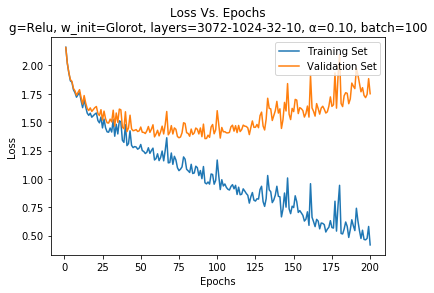

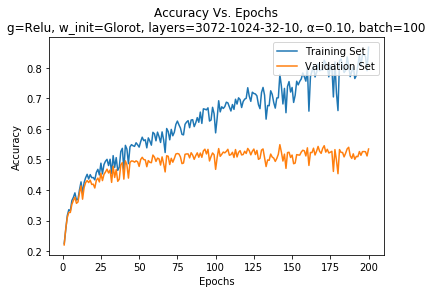

In [ ]:
    trainset,validation,_=loaddata()
    print(trainset.data.shape)
    print(validation.data.shape)
    net = NNFactory.create(hidden_dims=[1024,32], activation=Relu, weight_init=Glorot)
    
    stats = net.train(trainset, validation, alpha=0.1, batch_size=100,epochs=200)
    plot_training_stats(stats, plot_title=net.training_info_label, plot_acc=True)

## final-train 
Train the model on the selected Epochs


TRAINING: g=Relu, w_init=Glorot, layers=3072-1024-32-10, α=0.10, batch=100
Epoch 1: TrainLoss=2.159905, TrainAcc=0.224356, ValidLoss=2.157254, ValidAcc=0.220200
Epoch 2: TrainLoss=2.018398, TrainAcc=0.271422, ValidLoss=2.018957, ValidAcc=0.272200
Epoch 3: TrainLoss=1.932776, TrainAcc=0.315756, ValidLoss=1.936361, ValidAcc=0.309400
Epoch 4: TrainLoss=1.864193, TrainAcc=0.335400, ValidLoss=1.874733, ValidAcc=0.326600
Epoch 5: TrainLoss=1.851984, TrainAcc=0.331467, ValidLoss=1.859557, ValidAcc=0.326400
Epoch 6: TrainLoss=1.785775, TrainAcc=0.365156, ValidLoss=1.796877, ValidAcc=0.352600
Epoch 7: TrainLoss=1.759642, TrainAcc=0.375711, ValidLoss=1.775767, ValidAcc=0.365800
Epoch 8: TrainLoss=1.720022, TrainAcc=0.390489, ValidLoss=1.736299, ValidAcc=0.376200
Epoch 9: TrainLoss=1.742273, TrainAcc=0.366978, ValidLoss=1.762375, ValidAcc=0.356200
Epoch 10: TrainLoss=1.761768, TrainAcc=0.370089, ValidLoss=1.785937, ValidAcc=0.360600
Epoch 11: TrainLoss=1.689522, TrainAcc=0.400533, ValidLoss=1.71

DONE (1526s): g=Relu, w_init=Glorot, layers=3072-1024-32-10, α=0.10, batch=100 - ValidAcc=0.533400


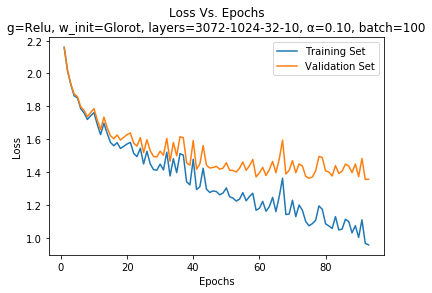

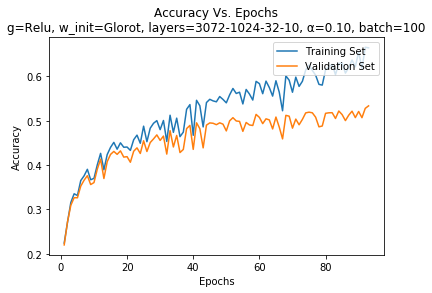

In [ ]:

    net = NNFactory.create(hidden_dims=[1024,32], activation=Relu, weight_init=Glorot)
    stats = net.train(trainset, trainset, alpha=0.1, batch_size=100,epochs=93)
    plot_training_stats(stats, plot_title=net.training_info_label, plot_acc=True)
    


### test the model
loss and accurecy of the testset

In [ ]:

net.test(testset.data.T,testset.targets.T)

(1.3161259275625041, 0.5436)